Ejemplos 18. Se va a comparar la solución analítica de la posición, velocidad y aceleración del émbolo (simbólico)
con las numéricas obtenidas utilizando las instrucciones gradient y derivative, tomando un paso h=0.01 y
considerando que L1=1, L2=2. La comparación se realiza en una vuelta, cada n grados.

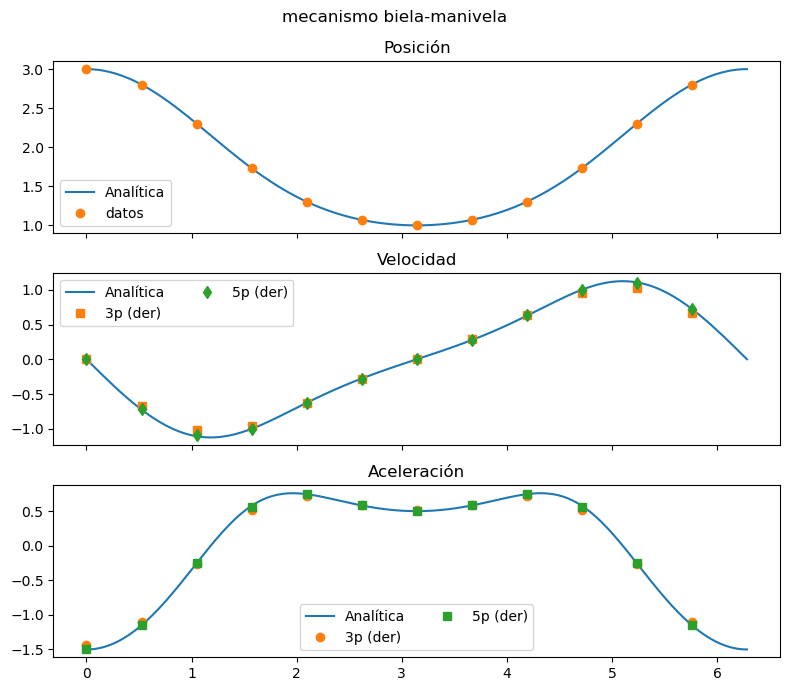

In [1]:
# ==============================================
# 1) Librerías y valores iniciales
# ==============================================
import sympy as sp                 # Cálculo simbólico (derivadas/expresiones)
import numpy as np                 # Cálculo numérico (vectores/arreglos)
import matplotlib.pyplot as plt    # Gráficas

# Parámetros del mecanismo (longitudes L1, L2), paso h (en rad) y n (grados)
L1, L2, h, n = (1, 2, 0.01, 30)

# ==============================================
# 2) Variables y funciones simbólicas
# ==============================================
xs = sp.symbols('xs', real=True)   # Ángulo simbólico
a  = sp.symbols('L_:2', real=True) # Crea símbolos a[0]=L_0 y a[1]=L_1

# Asignación numérica para las longitudes
valor = {a[0]: L1, a[1]: L2}

# Posición simbólica x(θ) del émbolo para una biela-manivela (modelo clásico)
pos = a[0]*sp.cos(xs) + sp.sqrt(a[1]**2 - a[0]**2*sp.sin(xs)**2)

# Derivadas simbólicas: velocidad y aceleración (respecto a θ)
vel = sp.diff(pos, xs).simplify()
ace = sp.diff(vel, xs).simplify()

# ==============================================
# 3) Conversión a funciones numéricas (lambdify)
# ==============================================
posa = sp.lambdify(xs, pos.subs(valor))  # x(θ)
vela = sp.lambdify(xs, vel.subs(valor))  # x'(θ)
acea = sp.lambdify(xs, ace.subs(valor))  # x''(θ)

# Malla “fina” para comparar y graficar (201 puntos de 0 a 2π)
Theta = np.linspace(0, 2*np.pi, 201)
Xa = posa(Theta)     # Posición analítica
Va = vela(Theta)     # Velocidad analítica
Aa = acea(Theta)     # Aceleración analítica

# ==============================================
# 4) Cálculos cada n grados  (ARREGLO PERIODICIDAD)
# ==============================================

puntos = int(np.ceil(360/n))              # Calcula el número de puntos según el paso angular n (en grados)
theta  = np.linspace(0, 2*np.pi, puntos,  # Genera los ángulos igualmente espaciados entre 0 y 2π
                     endpoint=False)      # Evita duplicar el punto final 2π (mantiene periodicidad)
Xn     = posa(theta)                      # Evalúa la posición analítica en cada ángulo θ
dtheta = theta[1] - theta[0]              # Calcula el incremento angular entre puntos consecutivos

# ==============================================
# 5) Derivadas numéricas periódicas
#     (central, usando np.roll para desplazar el arreglo)
# ==============================================

# ---- 3 puntos (O(h^2)) ----
# Fórmulas centrales clásicas de 3 puntos (segundo orden)
# Primera derivada: f'(x) ≈ (f(x+h) - f(x-h)) / (2h)
Vn3d = (np.roll(Xn, -1) - np.roll(Xn, 1)) / (2*dtheta)

# Segunda derivada: f''(x) ≈ (f(x+h) - 2f(x) + f(x-h)) / h²
An3d = (np.roll(Xn, -1) - 2*Xn + np.roll(Xn, 1)) / (dtheta**2)

# ---- 5 puntos (O(h^4)) ----  (RECOMENDADO)
# Fórmulas centrales de 5 puntos (cuarto orden de precisión)
# Primera derivada: (-f(x+2h) + 8f(x+h) - 8f(x-h) + f(x-2h)) / (12h)
Vn5d = (-np.roll(Xn, -2) + 8*np.roll(Xn, -1)
        - 8*np.roll(Xn,  1) +  np.roll(Xn,  2)) / (12*dtheta)

# Segunda derivada: (-f(x+2h)+16f(x+h)-30f(x)+16f(x-h)-f(x-2h)) / (12h²)
An5d = (-np.roll(Xn, -2) + 16*np.roll(Xn, -1) - 30*Xn
        + 16*np.roll(Xn,  1) -  np.roll(Xn,  2)) / (12*dtheta**2)

# ---- 7 puntos (O(h^6)) ----  (OPCIONAL, aún más exacto)
# Fórmulas centrales de 7 puntos (sexto orden de precisión)
# Primera derivada: (f(-3)-9f(-2)+45f(-1)-45f(1)+9f(2)-f(3)) / (60h)
Vn7d = ( np.roll(Xn,  3) - 9*np.roll(Xn,  2) + 45*np.roll(Xn,  1)
        -45*np.roll(Xn, -1) + 9*np.roll(Xn, -2) -  np.roll(Xn, -3)) / (60*dtheta)

# Segunda derivada:
# (2f(-3)-27f(-2)+270f(-1)-490f(0)+270f(1)-27f(2)+2f(3)) / (180h²)
An7d = ( 2*np.roll(Xn,  3) - 27*np.roll(Xn,  2) + 270*np.roll(Xn,  1)
        -490*Xn
        +270*np.roll(Xn, -1) - 27*np.roll(Xn, -2) +  2*np.roll(Xn, -3)) / (180*dtheta**2)

# ==============================================
# 6) Gráficas de comparación
# ==============================================
fig, ax = plt.subplots(3, 1, figsize=(8, 7), sharex=True)
plt.suptitle("mecanismo biela-manivela")

# --- Posición ---
ax[0].set_title("Posición")
ax[0].plot(Theta, Xa, label="Analítica")
ax[0].plot(theta, Xn, "o", label="datos")
ax[0].legend()

# --- Velocidad ---
ax[1].set_title("Velocidad")
ax[1].plot(Theta, Va, label="Analítica")
ax[1].plot(theta, Vn3d, "s", label="3p (der)")   # 3 puntos (central)
ax[1].plot(theta, Vn5d, "d", label="5p (der)")   # 5 puntos (central)
ax[1].legend(ncol=2)

# --- Aceleración ---
ax[2].set_title("Aceleración")
ax[2].plot(Theta, Aa, label="Analítica")
ax[2].plot(theta, An3d, "o", label="3p (der)")   # segunda derivada 3p
ax[2].plot(theta, An5d, "s", label="5p (der)")   # segunda derivada 5p
ax[2].legend(ncol=2)

fig.tight_layout()
plt.show()


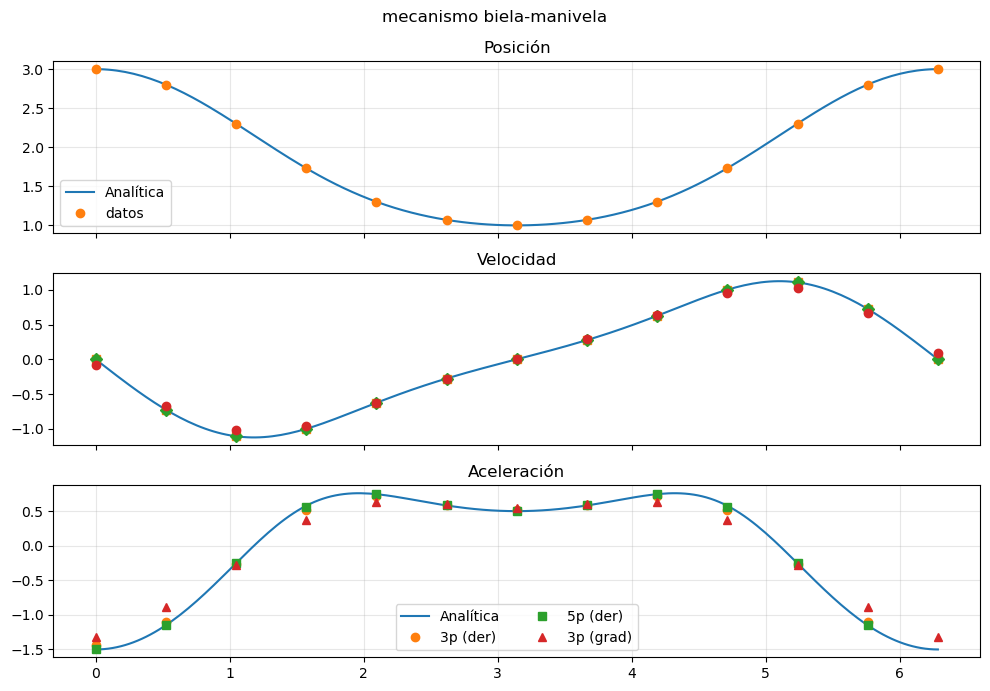

In [2]:
# ================================
# 1. Carga de las librerías y valores iniciales
# ================================
import sympy as sp                 # Librería para cálculo simbólico
import numpy as np                 # Librería para cálculo numérico con matrices y vectores
from scipy.differentiate import derivative  # Para derivadas numéricas
import matplotlib.pyplot as plt    # Librería para graficar resultados

L1, L2, h, n = (1, 2, 0.01, 30)    # Valores iniciales: longitudes L1, L2, paso h y número n

# ================================
# 2. Definición genérica de variables y funciones simbólicas
# ================================
xs = sp.symbols('xs', real=True)   # Ángulo simbólico
a = sp.symbols("L_:2", real=True)  # Crea símbolos L_0 y L_1 como variables reales
valor = {a[0]: L1, a[1]: L2}       # Asigna valores numéricos a los símbolos creados

# Definición de la posición simbólica en función de xs
pos = (a[0]*sp.cos(xs) + sp.sqrt(a[1]**2 - a[0]**2*sp.sin(xs)**2))

# Derivadas simbólicas de posición (velocidad y aceleración)
vel = pos.diff(xs).simplify()      # Primera derivada: velocidad
ace = vel.diff(xs).simplify()      # Segunda derivada: aceleración

# ================================
# 3. Conversión a funciones numéricas para comparar y representar
# ================================
# Convierte las expresiones simbólicas a funciones numéricas (lambdify)
posa = sp.lambdify(xs, pos.subs(valor))  # Función numérica de posición
vela = sp.lambdify(xs, vel.subs(valor))  # Función numérica de velocidad
acea = sp.lambdify(xs, ace.subs(valor))  # Función numérica de aceleración

# Define el rango de ángulos para evaluar (de 0 a 2π)
Theta = np.linspace(0, 2*np.pi, 201)

# Evalúa las funciones numéricas en el rango definido
Xa = posa(Theta)   # Posición
Va = vela(Theta)   # Velocidad
Aa = acea(Theta)   # Aceleración

# ================================
# 4. Cálculos cada n grados
# ================================
puntos = int(np.ceil(360/n) + 1)         # Calcula el número de puntos en base a n grados
theta = np.linspace(0, 2*np.pi, puntos)  # Genera los valores de θ
Xn = posa(theta)                         # Calcula posición numérica en esos puntos

# --- Usando derivative: sólo la primera derivada ---
Vn3d = derivative(posa, theta, order=2, maxiter=1, initial_step=h)  # Derivada numérica (orden 2)
Vn5d = derivative(posa, theta, order=4, maxiter=1, initial_step=h)  # Derivada numérica (orden 4)

# --- Usando gradient y encadenando derivadas ---
Vn3g = np.gradient(Xn, theta, edge_order=2)        # Derivada numérica (velocidad)
An3g = np.gradient(Vn3g, theta, edge_order=2)      # Segunda derivada (aceleración)

# --- Helpers para graficar con seguridad ---
def _yvals(v):
    """Extrae la parte numérica de un posible RichResult o array."""
    if hasattr(v, "df"):
        return np.asarray(v.df)
    if hasattr(v, "derivative"):
        return np.asarray(v.derivative)
    return np.asarray(v)

def _plot_xy(ax, x, y, *args, **kwargs):
    """Grafica x vs y recortando al mismo tamaño si difieren."""
    x = np.asarray(x); y = _yvals(y)
    m = min(x.shape[0], y.shape[0])
    ax.plot(x[:m], y[:m], *args, **kwargs)

# ============================
# 5) Representación de resultados
# ============================

fig, ax = plt.subplots(3, 1, figsize=(10, 7), sharex=True)
plt.suptitle("mecanismo biela-manivela")

# ----- Posición -----
ax[0].set_title("Posición")
ax[0].plot(Theta, Xa, label="Analítica")
ax[0].plot(theta, Xn, "o", label="datos")
ax[0].legend()
ax[0].grid(True, alpha=0.3)

# ----- Velocidad -----
ax[1].set_title("Velocidad")
ax[1].plot(Theta, Va, label="Analítica")

if 'Vn3d' in locals():
    _plot_xy(ax[1], theta, Vn3d, "s", label="3p (der)")
if 'Vn5d' in locals():
    _plot_xy(ax[1], theta, Vn5d, "D", label="5p (der)")
if 'Vn3g' in locals():
    _plot_xy(ax[1], theta, Vn3g, "o", label="3p (grad)")

# ----- Aceleración -----
ax[2].set_title("Aceleración")
ax[2].plot(Theta, Aa, label="Analítica")

if 'An3d' in locals():
    _plot_xy(ax[2], theta, An3d, "o", label="3p (der)")
if 'An5d' in locals():
    _plot_xy(ax[2], theta, An5d, "s", label="5p (der)")
if 'An3g' in locals():
    _plot_xy(ax[2], theta, An3g, "^", label="3p (grad)")

ax[2].legend(ncol=2)
ax[2].grid(True, alpha=0.3)

fig.tight_layout()
plt.show()



In [3]:
import findiff

In [4]:
from fractions import Fraction
from collections.abc import Iterable

def dncoef_base(soporte, puntos, orden):
    """
    Calcula los coeficientes de una regla de derivación numérica
    usando los polinomios de la base de Lagrange definidos por 'soporte'.

    Parámetros:
    -----------
    soporte : lista o tupla
        Nodos del soporte (x_k)
    puntos : escalar o iterable
        Punto o puntos donde se evalúan las derivadas
    orden : int
        Orden de la derivada (entero >=0 y < len(soporte))

    Devuelve:
    ----------
    coef : lista de coeficientes (o lista de listas si 'puntos' es iterable)
    """

    # --- Funciones auxiliares ---
    def _is_scalar(x):
        return not isinstance(x, Iterable) or isinstance(x, (str, bytes, bytearray))

    def _poly_mul(p, q):
        res = [Fraction(0) for _ in range(len(p) + len(q) - 1)]
        for i, a in enumerate(p):
            for j, b in enumerate(q):
                res[i + j] += a * b
        return res

    def _poly_deriv(p, m=1):
        for _ in range(m):
            if len(p) == 1:
                return [Fraction(0)]
            p = [p[i+1] * (i+1) for i in range(len(p) - 1)]
        return p

    def _poly_eval(p, x):
        acc = Fraction(0)
        for c in reversed(p):
            acc = acc * x + c
        return acc

    def _lagrange_basis(xs, k):
        n = len(xs)
        num = [Fraction(1)]
        den = Fraction(1)
        xk = xs[k]
        for j, xj in enumerate(xs):
            if j == k:
                continue
            num = _poly_mul(num, [Fraction(-xj), Fraction(1)])
            den *= (xk - xj)
        num = [c / den for c in num]
        return num

    # --- 1) Comprobación de datos de entrada ---
    if not isinstance(soporte, (list, tuple)):
        raise TypeError("El soporte debe ser lista o tupla.")
    n = len(soporte)
    if not isinstance(orden, int) or not (0 <= orden < n):
        raise ValueError("El orden debe ser entero y menor que el número de nodos del soporte.")

    # Convertir a fracciones para exactitud
    xs = [Fraction(s).limit_denominator() for s in soporte]

    # --- 2) Base de Lagrange ---
    base = [_lagrange_basis(xs, k) for k in range(n)]

    # --- 3) Derivar cada polinomio de la base ---
    dbase = [_poly_deriv(p, orden) for p in base]

    # --- 4) Evaluar en el/los puntos ---
    def coef_en(a):
        aF = Fraction(a).limit_denominator()
        return [_poly_eval(p, aF) for p in dbase]

    if _is_scalar(puntos):
        return coef_en(puntos)
    else:
        return [coef_en(a) for a in puntos]


In [5]:
# Caso 1
xs1 = [i/12 for i in range(5)]
print(dncoef_base(xs1, 0, 1))
# → [-25, 48, -36, 16, -3]

# Caso 2
xs2 = [0, 1, 2, 3]
print(dncoef_base(xs2, 1, 2))
# → [1, -2, 1, 0]

# Caso 3
xs3 = [0, 0.5, 1, 1.5, 2]
print(dncoef_base(xs3, 0.5, 3))
# → [-12, 40, -48, 24, -4]


[Fraction(-25, 1), Fraction(48, 1), Fraction(-36, 1), Fraction(16, 1), Fraction(-3, 1)]
[Fraction(1, 1), Fraction(-2, 1), Fraction(1, 1), Fraction(0, 1)]
[Fraction(-12, 1), Fraction(40, 1), Fraction(-48, 1), Fraction(24, 1), Fraction(-4, 1)]


In [6]:
# --- Test cases with asserts ---

# Caso 1
xs1 = [i/12 for i in range(5)]
coef1 = dncoef_base(xs1, 0, 1)
print("Caso 1:", coef1)
assert coef1 == [-25, 48, -36, 16, -3], "❌ Caso 1 incorrecto"

# Caso 2
xs2 = [0, 1, 2, 3]
coef2 = dncoef_base(xs2, 1, 2)
print("Caso 2:", coef2)
assert coef2 == [1, -2, 1, 0], "❌ Caso 2 incorrecto"

# Caso 3
xs3 = [0, 0.5, 1, 1.5, 2]
coef3 = dncoef_base(xs3, 0.5, 3)
print("Caso 3:", coef3)
assert coef3 == [-12, 40, -48, 24, -4], "❌ Caso 3 incorrecto"

print("\n✅ Todos los casos verificados correctamente.")

def assert_suma_coef(soporte, a, m, tol=1e-10):
    alphas = dncoef_base(soporte, a, m)
    s = sum(alphas)
    if m == 0:
        assert abs(s - 1.0) < tol, f"Suma debe ser 1, obtuve {s}"
    else:
        assert abs(s) < tol, f"Suma debe ser 0, obtuve {s}"
    return alphas

# Casos del enunciado + verificación de suma
xs1 = [i/12 for i in range(5)]
a1  = 0
m1  = 1
coef1 = assert_suma_coef(xs1, a1, m1)             # también chequea suma==0
assert coef1 == [-25.0, 48.0, -36.0, 16.0, -3.0]

xs2 = [0, 1, 2, 3]
a2, m2 = 1, 2
coef2 = assert_suma_coef(xs2, a2, m2)
assert coef2 == [1.0, -2.0, 1.0, 0.0]

xs3 = [0, 0.5, 1, 1.5, 2]
a3, m3 = 0.5, 3
coef3 = assert_suma_coef(xs3, a3, m3)
assert coef3 == [-12.0, 40.0, -48.0, 24.0, -4.0]

print("✅ Suma de coeficientes verificada en los 3 casos.")



Caso 1: [Fraction(-25, 1), Fraction(48, 1), Fraction(-36, 1), Fraction(16, 1), Fraction(-3, 1)]
Caso 2: [Fraction(1, 1), Fraction(-2, 1), Fraction(1, 1), Fraction(0, 1)]
Caso 3: [Fraction(-12, 1), Fraction(40, 1), Fraction(-48, 1), Fraction(24, 1), Fraction(-4, 1)]

✅ Todos los casos verificados correctamente.
✅ Suma de coeficientes verificada en los 3 casos.


In [7]:
from collections.abc import Iterable
from math import isclose

def dncoef_base_simple(soporte, puntos, orden, *, tol=1e-12, redondear_enteros=True):
    """
    Igual que dncoef_base pero con floats (sin fractions).

    soporte : lista/tupla de nodos
    puntos  : escalar o iterable
    orden   : orden de la derivada
    tol     : tolerancia para redondear valores muy cercanos a enteros
    redondear_enteros : si True, convierte 2.999999999999 -> 3
    """

    def _is_scalar(x):
        return not isinstance(x, Iterable) or isinstance(x, (str, bytes, bytearray))

    def _poly_mul(p, q):
        res = [0.0]*(len(p)+len(q)-1)
        for i, a in enumerate(p):
            for j, b in enumerate(q):
                res[i+j] += a*b
        return res

    def _poly_deriv(p, m=1):
        for _ in range(m):
            if len(p) == 1:
                return [0.0]
            p = [p[i+1]*(i+1) for i in range(len(p)-1)]
        return p

    def _poly_eval(p, x):
        acc = 0.0
        for c in reversed(p):
            acc = acc*x + c
        return acc

    def _lagrange_basis(xs, k):
        num = [1.0]
        den = 1.0
        xk = xs[k]
        for j, xj in enumerate(xs):
            if j == k: 
                continue
            num = _poly_mul(num, [-xj, 1.0])   # (x - xj)
            den *= (xk - xj)
        return [c/den for c in num]

    def _redondeo(lst):
        if not redondear_enteros:
            return lst
        out = []
        for x in lst:
            xi = round(x)
            out.append(float(xi) if abs(x - xi) < tol else x)
        return out

    # --- comprobaciones ---
    if not isinstance(soporte, (list, tuple)):
        raise TypeError("El soporte debe ser lista o tupla.")
    n = len(soporte)
    if not isinstance(orden, int) or not (0 <= orden < n):
        raise ValueError("El orden debe ser entero y menor que el número de nodos del soporte.")

    xs = [float(s) for s in soporte]
    base = [_lagrange_basis(xs, k) for k in range(n)]
    dbase = [_poly_deriv(p, orden) for p in base]

    def coef_en(a):
        a = float(a)
        vals = [_poly_eval(p, a) for p in dbase]
        return _redondeo(vals)

    if _is_scalar(puntos):
        return coef_en(puntos)
    else:
        return [coef_en(a) for a in puntos]


In [8]:
# Caso 1
xs1 = [i/12 for i in range(5)]
assert dncoef_base_simple(xs1, 0, 1) == [-25.0, 48.0, -36.0, 16.0, -3.0]

# Caso 2
xs2 = [0, 1, 2, 3]
assert dncoef_base_simple(xs2, 1, 2) == [1.0, -2.0, 1.0, 0.0]

# Caso 3
xs3 = [0, 0.5, 1, 1.5, 2]
assert dncoef_base_simple(xs3, 0.5, 3) == [-12.0, 40.0, -48.0, 24.0, -4.0]


In [9]:
def assert_suma_coef(soporte, a, m, tol=1e-10):
    alphas = dncoef_base_simple(soporte, a, m)
    s = sum(alphas)
    if m == 0:
        assert abs(s - 1.0) < tol, f"Suma debe ser 1, obtuve {s}"
    else:
        assert abs(s) < tol, f"Suma debe ser 0, obtuve {s}"
    return alphas

# Casos del enunciado + verificación de suma
xs1 = [i/12 for i in range(5)]
a1  = 0
m1  = 1
coef1 = assert_suma_coef(xs1, a1, m1)             # también chequea suma==0
assert coef1 == [-25.0, 48.0, -36.0, 16.0, -3.0]

xs2 = [0, 1, 2, 3]
a2, m2 = 1, 2
coef2 = assert_suma_coef(xs2, a2, m2)
assert coef2 == [1.0, -2.0, 1.0, 0.0]

xs3 = [0, 0.5, 1, 1.5, 2]
a3, m3 = 0.5, 3
coef3 = assert_suma_coef(xs3, a3, m3)
assert coef3 == [-12.0, 40.0, -48.0, 24.0, -4.0]

print("✅ Suma de coeficientes verificada en los 3 casos.")


✅ Suma de coeficientes verificada en los 3 casos.


In [10]:
import math

def assert_momentos(soporte, a, m, tol=1e-10):
    alphas = dncoef_base_simple(soporte, a, m)
    n = len(soporte)
    for p in range(n):
        mom = sum(alpha * (x - a)**p for alpha, x in zip(alphas, soporte))
        objetivo = math.factorial(m) if p == m else 0.0
        assert abs(mom - objetivo) < tol, f"Falla momento p={p}: {mom} vs {objetivo}"
    return True

# Ejemplo: chequear momentos también
assert_momentos(xs1, a1, m1)
assert_momentos(xs2, a2, m2)
assert_momentos(xs3, a3, m3)

print("✅ Condiciones de momentos verificadas.")


✅ Condiciones de momentos verificadas.


In [11]:
# --- helper: verifica beta == alpha / c**m ---
def check_affine(soporte_old, a_old, m, c, d, tol=1e-10):
    # nuevos nodos y punto a
    soporte_new = [c*x + d for x in soporte_old]
    a_new = c*a_old + d

    alpha = dncoef_base_simple(soporte_old, a_old, m, redondear_enteros=False)
    beta  = dncoef_base_simple(soporte_new, a_new, m, redondear_enteros=False)

    escala = c**m
    pred = [a/escala for a in alpha]

    # compara elemento a elemento
    for b, p in zip(beta, pred):
        assert abs(b - p) < tol, f"Affine fail: {b} vs {p}"
    return alpha, beta, pred

# ====== Fila 1 ======
# φ(x)=12x, m=1,  x_k={0,1,2,3,4}, a=0  (viene de {0,1/12,2/12,3/12,4/12}, a=0)
old1 = [i/12 for i in range(5)]
a1, m1, c1, d1 = 0.0, 1, 12.0, 0.0
alpha1, beta1, pred1 = check_affine(old1, a1, m1, c1, d1)

# ====== Fila 2 ======
# φ(x)=3x+10, m=2, x_k={10,13,16,19}, a=13 (viene de {0,1,2,3}, a=1)
old2 = [0,1,2,3]
a2, m2, c2, d2 = 1.0, 2, 3.0, 10.0
alpha2, beta2, pred2 = check_affine(old2, a2, m2, c2, d2)

# ====== Fila 3 ======
# φ(x)=2x-2, m=3, x_k={-2,-1,0,1,2}, a=-1 (viene de {0,1/2,1,3/2,2}, a=1/2)
old3 = [0,0.5,1,1.5,2]
a3, m3, c3, d3 = 0.5, 3, 2.0, -2.0
alpha3, beta3, pred3 = check_affine(old3, a3, m3, c3, d3)

print("✅ Relación afín verificada en las 3 filas.")
print("Fila 1  beta =", beta1, " = alpha/12 =", pred1)
print("Fila 2  beta =", beta2, " = alpha/9  =", pred2)
print("Fila 3  beta =", beta3, " = alpha/8  =", pred3)


✅ Relación afín verificada en las 3 filas.
Fila 1  beta = [-2.0833333333333335, 4.0, -3.0, 1.3333333333333333, -0.25]  = alpha/12 = [-2.0833333333333335, 3.9999999999999996, -2.9999999999999996, 1.3333333333333333, -0.25000000000000006]
Fila 2  beta = [0.1111111111111111, -0.22222222222222232, 0.11111111111111116, 0.0]  = alpha/9  = [0.1111111111111111, -0.2222222222222222, 0.1111111111111111, 0.0]
Fila 3  beta = [-1.5, 5.0, -6.0, 3.0, -0.5]  = alpha/8  = [-1.5, 5.0, -6.0, 3.0, -0.5]


In [12]:
def check_simetria(soporte, a, m, tol=1e-10):
    """
    Verifica la propiedad de simetría:
    α(a+δ) = (-1)^m * α(a−δ)
    """
    alphas = dncoef_base_simple(soporte, a, m, redondear_enteros=False)
    xs = soporte
    s = (-1)**m
    n = len(xs)
    sim = True

    # Empareja desde los extremos hacia el centro
    for i in range(n//2):
        j = n - 1 - i
        ai, aj = alphas[i], alphas[j]
        if abs(ai - s * aj) > tol:
            sim = False
            print(f"❌ No cumple simetría: α[{i}]={ai}, α[{j}]={aj}, esperado {s*aj}")
    if sim:
        print(f"✅ Orden m={m}: cumple simetría con respecto a a={a}")
    return alphas


# ===== Casos del Ejemplo 21 =====
# Caso 1
xs1, a1, m1 = [0,1,2,3,4], 2, 1
coef1 = check_simetria(xs1, a1, m1)

# Caso 2
xs2, a2, m2 = [0,1,2,3], 1.5, 2
coef2 = check_simetria(xs2, a2, m2)

# Caso 3
xs3, a3, m3 = [-2,-1,0,1,2], 0, 3
coef3 = check_simetria(xs3, a3, m3)

print("\nCoeficientes calculados:")
print(f"m=1: {coef1}")
print(f"m=2: {coef2}")
print(f"m=3: {coef3}")


✅ Orden m=1: cumple simetría con respecto a a=2
✅ Orden m=2: cumple simetría con respecto a a=1.5
✅ Orden m=3: cumple simetría con respecto a a=0

Coeficientes calculados:
m=1: [0.0833333333333326, -0.6666666666666643, 0.0, 0.6666666666666672, -0.08333333333333348]
m=2: [0.5, -0.5, -0.5, 0.5]
m=3: [-0.5, 1.0, 0.0, -1.0, 0.5]


In [13]:
def check_simetria(soporte, a, m, tol=1e-10):
    """
    Verifica y muestra la propiedad de simetría de los coeficientes
    α(a+δ) = (-1)^m * α(a−δ)
    """

    alphas = dncoef_base_simple(soporte, a, m, redondear_enteros=False)
    xs = soporte
    signo = (-1)**m
    n = len(xs)
    centro = a
    simetrico = True

    print(f"\n🔹 Comprobando simetría para m={m}, a={a}")
    print("Nodos y coeficientes:")
    for x, c in zip(xs, alphas):
        print(f"  x={x:6.3f}  α={c:10.6f}")

    print("\nComprobación de pares simétricos:")
    for i in range(n//2):
        j = n - 1 - i
        ai, aj = alphas[i], alphas[j]
        delta_i, delta_j = xs[i] - a, xs[j] - a
        esperado = signo * aj
        cumple = abs(ai - esperado) < tol
        print(f"  δ_i={delta_i:+5.2f}, δ_j={delta_j:+5.2f} → "
              f"α[{i}]={ai:+10.6f}, α[{j}]={aj:+10.6f} "
              f"→ esperado {esperado:+10.6f}  {'✅' if cumple else '❌'}")
        if not cumple:
            simetrico = False

    if simetrico:
        tipo = "simétricos" if signo == 1 else "antisimétricos"
        print(f"✅ Orden m={m}: los coeficientes son {tipo} respecto a a={a}\n")
    else:
        print(f"❌ No cumple simetría exacta para m={m}\n")

    return alphas


# === Casos del Ejemplo 21 ===
xs1, a1, m1 = [0,1,2,3,4], 2, 1
xs2, a2, m2 = [0,1,2,3], 1.5, 2
xs3, a3, m3 = [-2,-1,0,1,2], 0, 3

coef1 = check_simetria(xs1, a1, m1)
coef2 = check_simetria(xs2, a2, m2)
coef3 = check_simetria(xs3, a3, m3)



🔹 Comprobando simetría para m=1, a=2
Nodos y coeficientes:
  x= 0.000  α=  0.083333
  x= 1.000  α= -0.666667
  x= 2.000  α=  0.000000
  x= 3.000  α=  0.666667
  x= 4.000  α= -0.083333

Comprobación de pares simétricos:
  δ_i=-2.00, δ_j=+2.00 → α[0]= +0.083333, α[4]= -0.083333 → esperado  +0.083333  ✅
  δ_i=-1.00, δ_j=+1.00 → α[1]= -0.666667, α[3]= +0.666667 → esperado  -0.666667  ✅
✅ Orden m=1: los coeficientes son antisimétricos respecto a a=2


🔹 Comprobando simetría para m=2, a=1.5
Nodos y coeficientes:
  x= 0.000  α=  0.500000
  x= 1.000  α= -0.500000
  x= 2.000  α= -0.500000
  x= 3.000  α=  0.500000

Comprobación de pares simétricos:
  δ_i=-1.50, δ_j=+1.50 → α[0]= +0.500000, α[3]= +0.500000 → esperado  +0.500000  ✅
  δ_i=-0.50, δ_j=+0.50 → α[1]= -0.500000, α[2]= -0.500000 → esperado  -0.500000  ✅
✅ Orden m=2: los coeficientes son simétricos respecto a a=1.5


🔹 Comprobando simetría para m=3, a=0
Nodos y coeficientes:
  x=-2.000  α= -0.500000
  x=-1.000  α=  1.000000
  x= 0.000  α